In [31]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os
from plot_data import plot_sensor_measurement, plot_sensor_calibration, plot_wind_rose


start_date = datetime(2023, 10, 16, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 10, 17, 23, 59, 59).replace(tzinfo=timezone.utc)

filter = '1h'

sensor_id = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20]
data_directory = "../data/"


In [32]:
# parquet created by notebook: perform_pivot_on_db.ipynb
df_new = pl.scan_parquet(os.path.join(data_directory, "pivot_measurements.parquet"))
# parquet created by notebook: Old Database/convert_old_parquet.ipynb
df_old = pl.scan_parquet(os.path.join(data_directory, "old_db_renamed_measurements.parquet"))
# parquet created by notebook: process_calibration_data.ipynb
df_cal = pl.scan_parquet(os.path.join(data_directory, "calibration_correction.parquet"))

columns = ["creation_timestamp",
           "system_name", 
            "cal_bottle_id",
            "gmp343_raw",
            "gmp343_compensated",
            "gmp343_filtered",
            "gmp343_temperature",
            "wxt532_speed_avg",
            "wxt532_speed_min",
            "wxt532_speed_max",
            "wxt532_direction_avg",
            "wxt532_direction_min",
            "wxt532_direction_max",
            "wxt532_last_update_time",
            "raspi_cpu_usage",
            "raspi_cpu_temperature",
            "raspi_disk_usage",
            "enclosure_bme280_humidity",
            "enclosure_bme280_pressure",
            "enclosure_bme280_temperature",
            "sht45_humidity",
            "sht45_temperature",
            "bme280_humidity",
            "bme280_temperature",
            "bme280_pressure",
            "cal_gmp343_filtered"]

# TODO: add all relevant columns

df_new = df_new.select(columns) \
.with_columns(pl.col("creation_timestamp").dt.cast_time_unit("us"))
df_old = df_old.select(columns) \
.with_columns(pl.col("creation_timestamp").dt.cast_time_unit("us"))

df = pl.concat([df_new, df_old]).sort("creation_timestamp")

df = df.sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# PICARRO data

In [33]:
picarro_path = r"/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/PICARRO"
#Calibration
picarro_slope = 1.0061589132696314
picarro_intercept = 0.14607153970888476


df_p = pl.scan_parquet(os.path.join(picarro_path, "picarro.parquet")) \
    .with_columns(pl.col("datetime").dt.cast_time_unit("us").dt.replace_time_zone("UTC").alias("creation_timestamp")) \
    .sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date)) \
    .with_columns((pl.col("CO2_dry") * picarro_slope + picarro_intercept).alias("CO2_corr")) \
    .groupby_dynamic("creation_timestamp", every='1h').agg(
                pl.all().exclude("creation_timestamp").mean()).collect() \
    .select(["creation_timestamp", "CO2_corr"]).with_columns([pl.lit(picarro_slope).alias("slope"),
                                                              pl.lit(picarro_intercept).alias("intercept"),
                                                              pl.lit("Picarro").alias("system_name")])

df_p.tail(3)

shape: (0, 5)
┌────────────────────┬──────────┬───────┬───────────┬─────────────┐
│ creation_timestamp ┆ CO2_corr ┆ slope ┆ intercept ┆ system_name │
│ ---                ┆ ---      ┆ ---   ┆ ---       ┆ ---         │
│ datetime[μs, UTC]  ┆ f64      ┆ f64   ┆ f64       ┆ str         │
╞════════════════════╪══════════╪═══════╪═══════════╪═════════════╡
└────────────────────┴──────────┴───────┴───────────┴─────────────┘

# Broadcast for multiple systems (semi working)

In [34]:
def broadcast_cal_corr(system):
    t1 = df.filter(pl.col("system_name") == system) \
        .select(["creation_timestamp", "system_name","gmp343_filtered"])  \
        .with_columns(pl.col("creation_timestamp").dt.date() \
        .alias("date"))

    t2 = df_cal.filter(pl.col("system_name") == system) \
        .select(["creation_timestamp", "system_name","slope","intercept"]) \
        .rename({"creation_timestamp": "date"})
        
    t1 = t1.join(t2, on = "date", how= "left") \
        .with_columns(pl.col("slope")) \
        .fill_null(strategy = "backward") \
        .fill_null(strategy = "forward") \
        .select(["creation_timestamp","system_name", "slope", "intercept"])
    
    t3 = df.sort("creation_timestamp") \
    .select(["creation_timestamp", "system_name","gmp343_filtered"])  \
    .join(t1, on=["system_name","creation_timestamp"], how= "left") \
    .filter(pl.col("system_name") == system)  \
    .filter(pl.col("gmp343_filtered") > 0) \
    .with_columns(((pl.col("gmp343_filtered") + 5) * pl.col("slope") + pl.col("intercept")) \
    .alias("CO2_corr")) \
    .collect() \
    .select(["creation_timestamp","system_name","CO2_corr","slope","intercept"]) \

    return t3

l_df_corr =[df_p]

for id in sensor_id:
    df_corr = broadcast_cal_corr(f"tum-esm-midcost-raspi-{id}")
    l_df_corr.append(df_corr.groupby_dynamic("creation_timestamp", every=filter)  \
                    .agg([pl.all().exclude(["creation_timestamp","system_name"]).mean(),
                         pl.col("system_name")]) \
                    .with_columns(pl.col("system_name").list.last())
                    )
    
df_corr_agg = pl.concat(l_df_corr, how="vertical")
df_corr_agg.tail(3)
                    

shape: (3, 5)
┌─────────────────────────┬──────────┬───────┬───────────┬──────────────────────────┐
│ creation_timestamp      ┆ CO2_corr ┆ slope ┆ intercept ┆ system_name              │
│ ---                     ┆ ---      ┆ ---   ┆ ---       ┆ ---                      │
│ datetime[μs, UTC]       ┆ f64      ┆ f64   ┆ f64       ┆ str                      │
╞═════════════════════════╪══════════╪═══════╪═══════════╪══════════════════════════╡
│ 2023-10-17 05:00:00 UTC ┆ null     ┆ null  ┆ null      ┆ tum-esm-midcost-raspi-20 │
│ 2023-10-17 06:00:00 UTC ┆ null     ┆ null  ┆ null      ┆ tum-esm-midcost-raspi-20 │
│ 2023-10-17 07:00:00 UTC ┆ null     ┆ null  ┆ null      ┆ tum-esm-midcost-raspi-20 │
└─────────────────────────┴──────────┴───────┴───────────┴──────────────────────────┘

In [35]:
import plotly.express as px


fig = px.line(df_corr_agg, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2", color="system_name")
fig.show()

fig = px.line(df_corr_agg, x="creation_timestamp", y=f"intercept", markers=True, title = "intercept", color="system_name")
fig.show()

fig = px.line(df_corr_agg, x="creation_timestamp", y=f"intercept", markers=True, title = "intercept", color="system_name")
fig.show()


/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Slow correction (faster through initial agg per hour)

In [36]:
dfg = df.groupby_dynamic("creation_timestamp", every="1h", by="system_name").agg(pl.col("gmp343_filtered").mean())

dfg.tail(3).collect()

shape: (3, 3)
┌──────────────────────────┬─────────────────────────┬─────────────────┐
│ system_name              ┆ creation_timestamp      ┆ gmp343_filtered │
│ ---                      ┆ ---                     ┆ ---             │
│ str                      ┆ datetime[μs, UTC]       ┆ f64             │
╞══════════════════════════╪═════════════════════════╪═════════════════╡
│ tum-esm-midcost-raspi-16 ┆ 2023-10-17 05:00:00 UTC ┆ 462.845         │
│ tum-esm-midcost-raspi-16 ┆ 2023-10-17 06:00:00 UTC ┆ 460.394708      │
│ tum-esm-midcost-raspi-16 ┆ 2023-10-17 07:00:00 UTC ┆ 466.225625      │
└──────────────────────────┴─────────────────────────┴─────────────────┘

In [37]:
def calibration_correction(date,name,item):
    try:
        intercept = df_cal.filter(pl.col('system_name') == name) \
            .filter(pl.col('creation_timestamp') < date).last() \
            .select("intercept").collect().item()
        slope = df_cal.filter(pl.col('system_name') == name) \
            .filter(pl.col('creation_timestamp') < date).last() \
            .select("slope").collect().item()
        
        return item * slope + intercept
    except:
        return None


df_m = dfg.filter(pl.col("gmp343_filtered") > 0) \
        .with_columns(pl.struct(['creation_timestamp','system_name','gmp343_filtered']) \
        .apply(lambda x: calibration_correction(x['creation_timestamp'],x['system_name'],x['gmp343_filtered'])) \
        .alias('gmp343_corrected'))

# Plot other data directly from database parquet

In [38]:
df = df.collect()

In [39]:
plot_sensor_measurement(df,sensor_id=sensor_id,col_name="gmp343_raw",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [40]:
plot_sensor_measurement(df,sensor_id,col_name="gmp343_compensated",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [41]:
plot_sensor_measurement(df,sensor_id,col_name="gmp343_filtered",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [42]:
# Maisach
plot_wind_rose(df,1, 'Maisach')
# Rechts-der-Isar
plot_wind_rose(df,2, 'Rechts-der-Isar')
# Finsing
plot_wind_rose(df,3, 'Finsing')
# Großhadern
plot_wind_rose(df,4, 'Großhadern')
# Großhadern
plot_wind_rose(df,5, 'Pasing')
# plot wind at 3m pole inlet
plot_wind_rose(df,7, 'TUM')

In [43]:
plot_sensor_measurement(df,sensor_id,col_name="wxt532_speed_avg",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [44]:
plot_sensor_measurement(df,sensor_id,col_name="wxt532_direction_avg",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [45]:
# Plot auxilliary data
plot_sensor_measurement(df,sensor_id,col_name="sht45_humidity",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [46]:
plot_sensor_measurement(df,sensor_id,col_name="bme280_humidity",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [47]:
plot_sensor_measurement(df,sensor_id,col_name="sht45_temperature",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [48]:
plot_sensor_measurement(df,sensor_id,col_name="bme280_temperature",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [49]:
plot_sensor_measurement(df,sensor_id,col_name="bme280_pressure",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [50]:
plot_sensor_measurement(df,sensor_id,col_name="gmp343_temperature",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [51]:
plot_sensor_measurement(df,sensor_id,col_name="raspi_cpu_usage",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [52]:
plot_sensor_measurement(df,sensor_id,col_name="raspi_disk_usage",filter=filter)


/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [53]:
#plot_sensor_measurement(df,sensor_id,col_name=,filter=filter)

In [54]:
plot_sensor_measurement(df,sensor_id,col_name="raspi_cpu_temperature",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [55]:
plot_sensor_measurement(df,sensor_id,col_name="enclosure_bme280_humidity",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [56]:
plot_sensor_measurement(df,sensor_id,col_name="enclosure_bme280_pressure",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [57]:
plot_sensor_measurement(df,sensor_id,col_name="enclosure_bme280_temperature",filter=filter)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

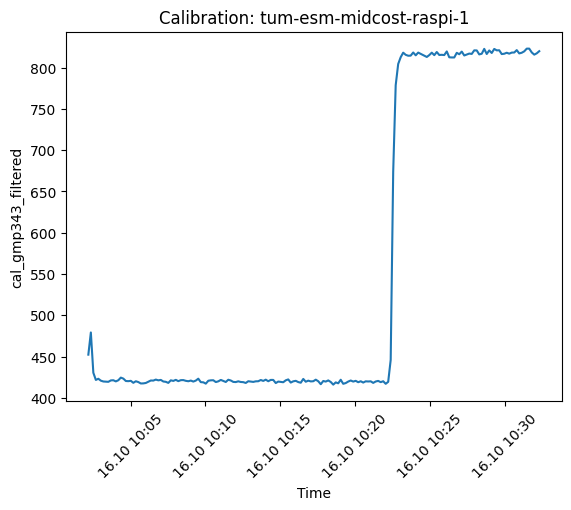

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

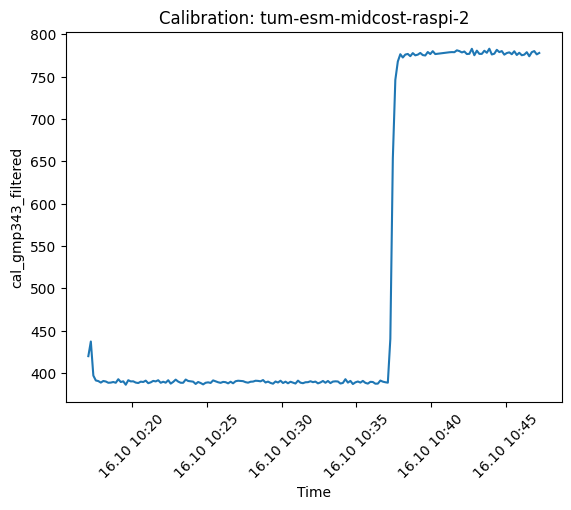

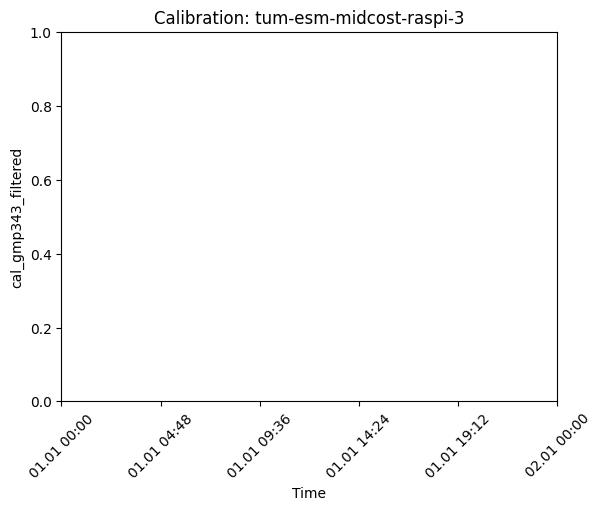

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

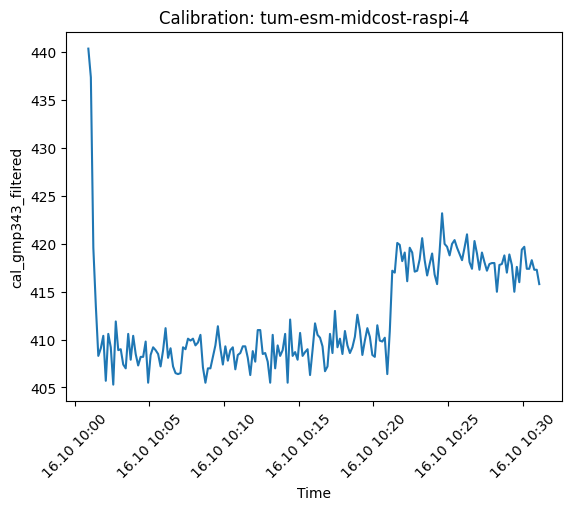

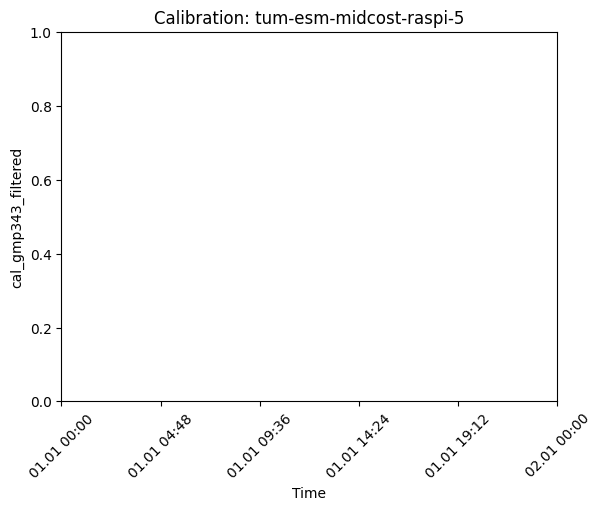

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

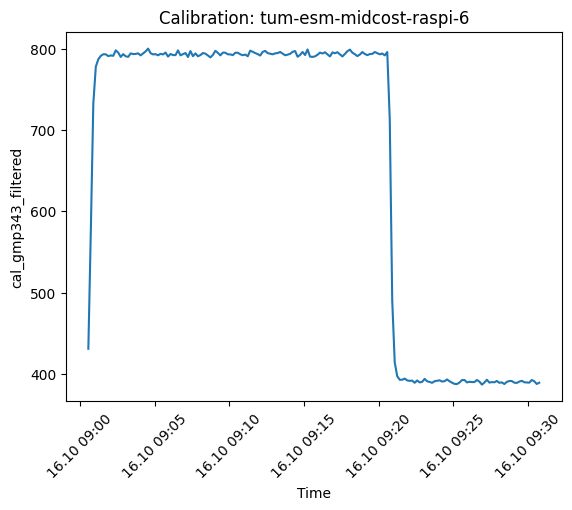

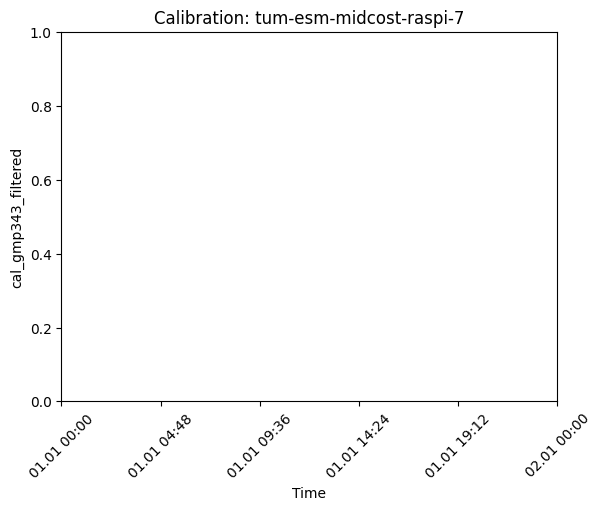

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

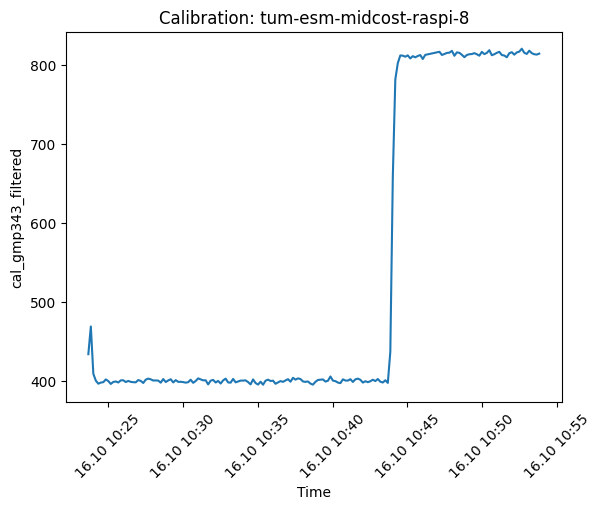

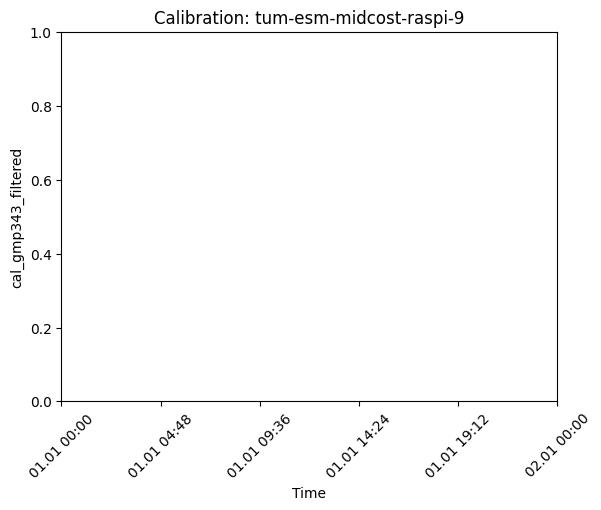

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

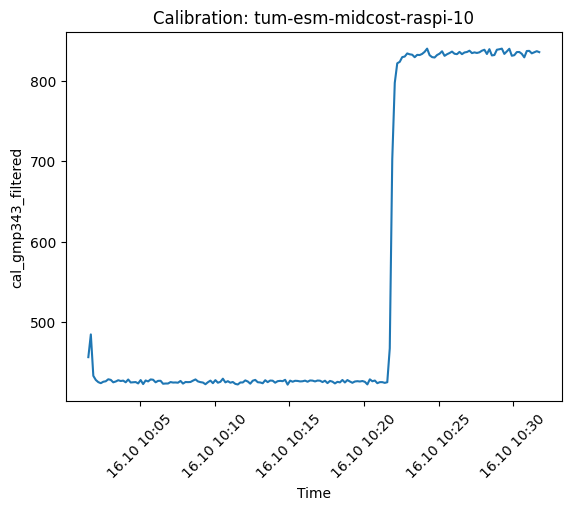

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

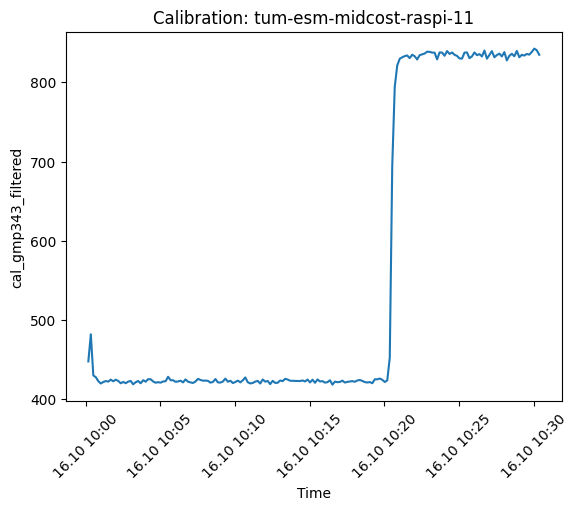

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

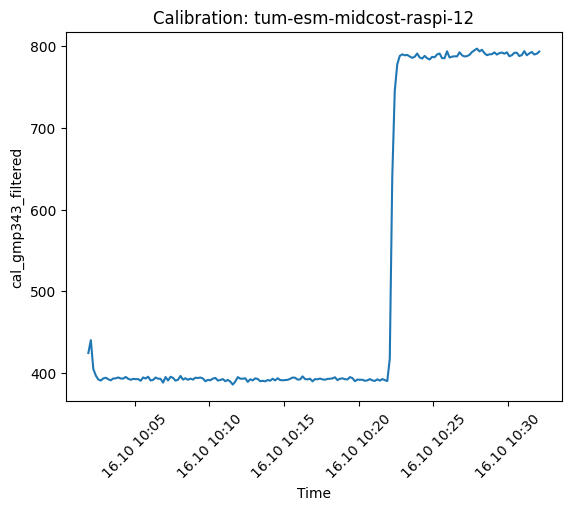

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

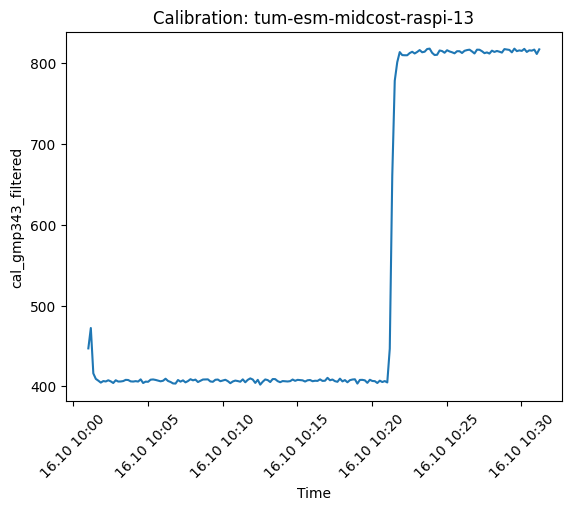

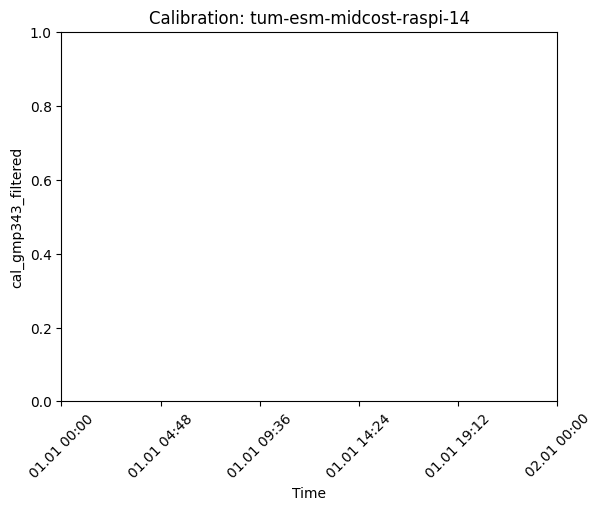

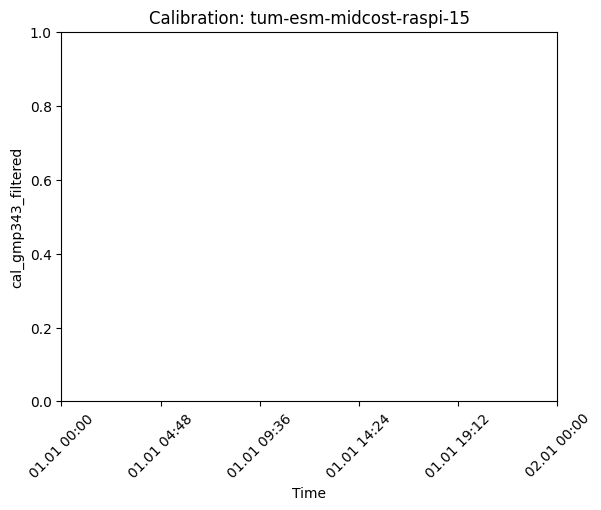

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

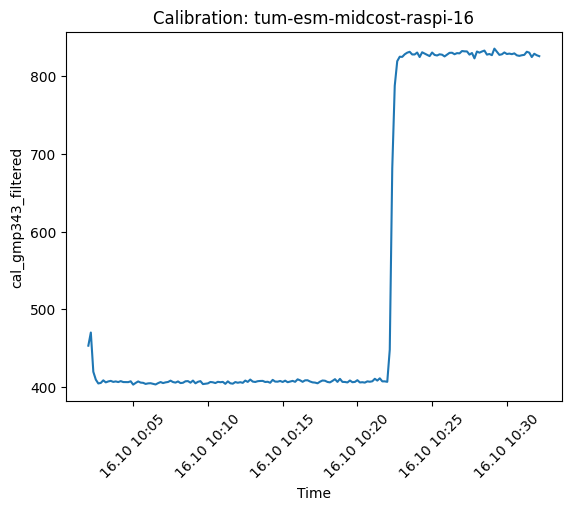

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

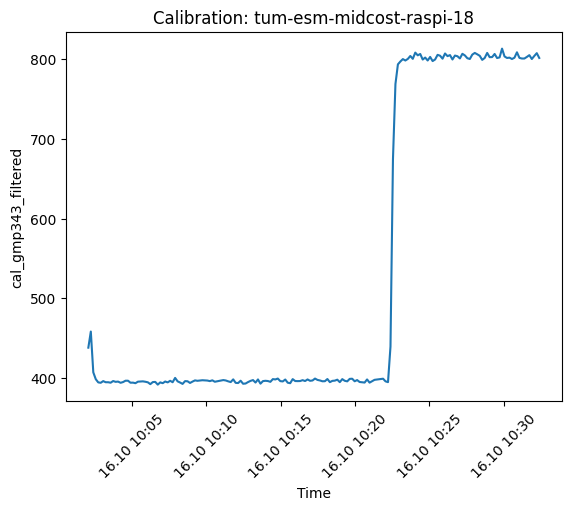

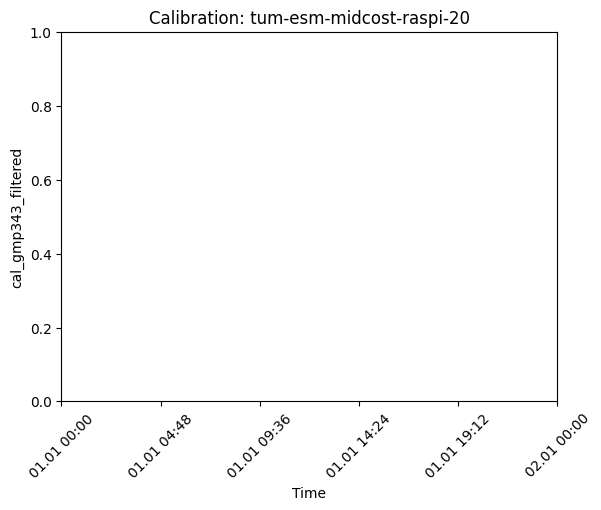

In [58]:
# Plot Calibration Data 
plot_sensor_calibration(df, col_name = "cal_gmp343_filtered", sensor_id=sensor_id, filter = None)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

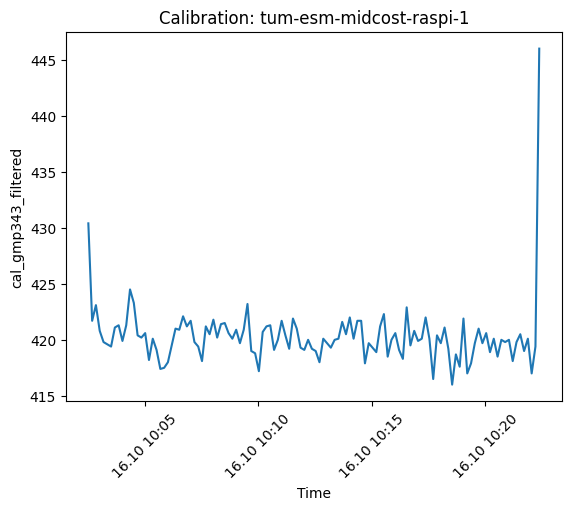

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

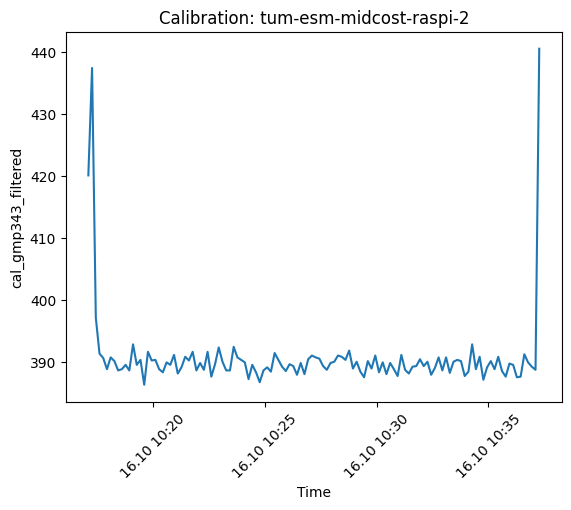

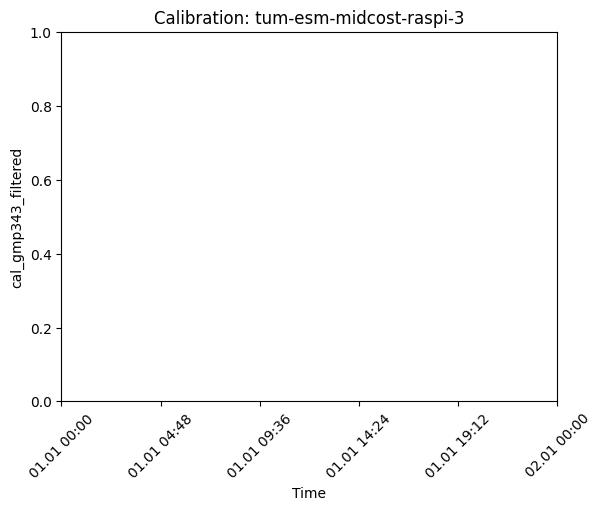

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

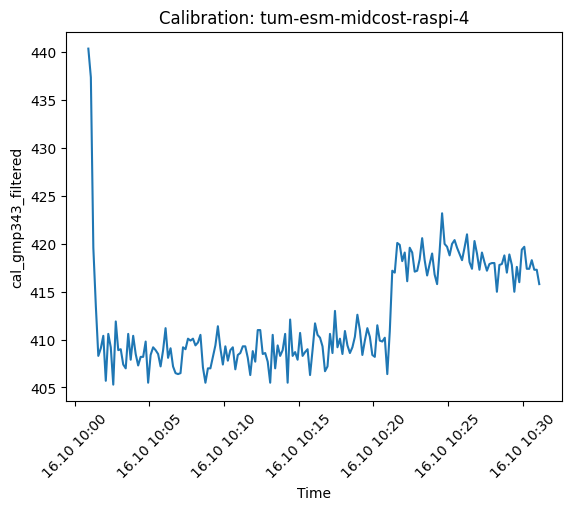

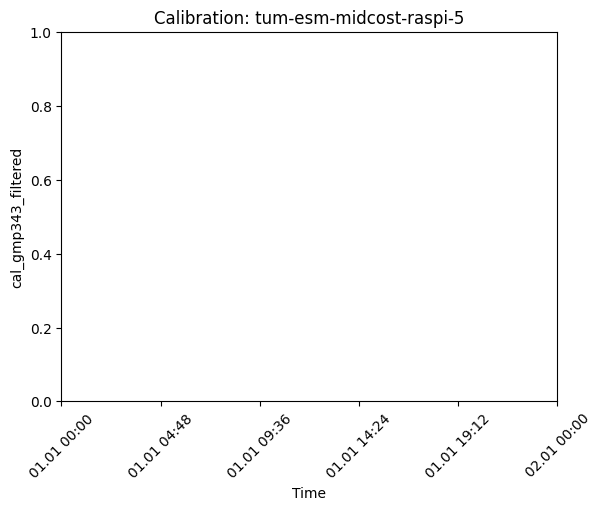

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

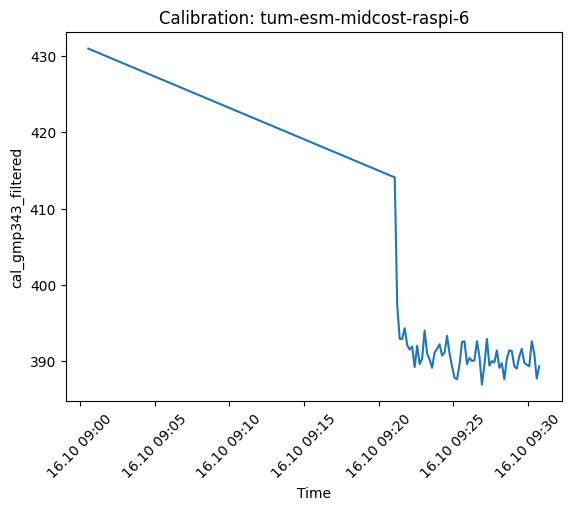

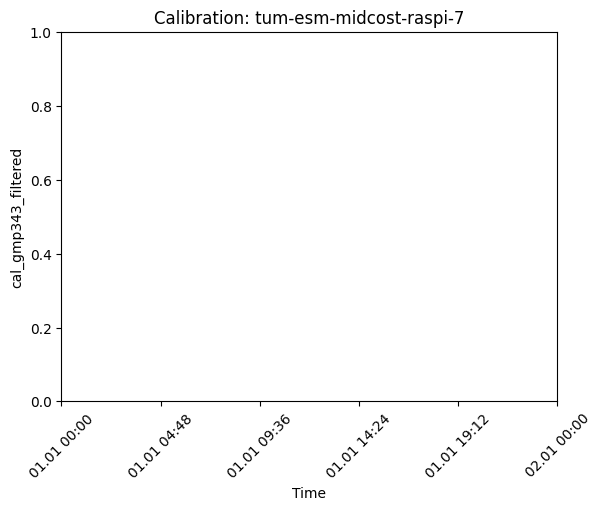

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

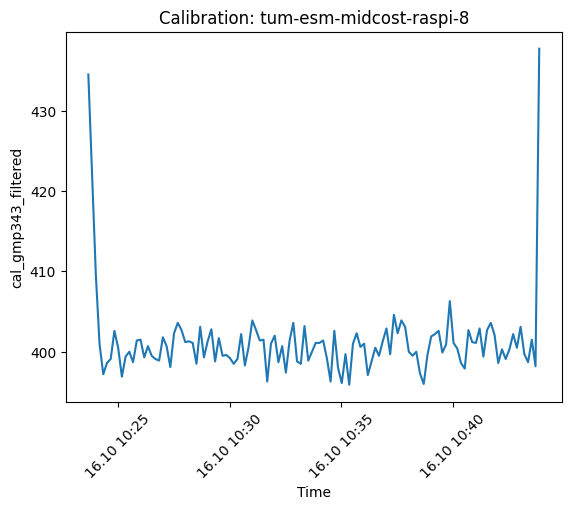

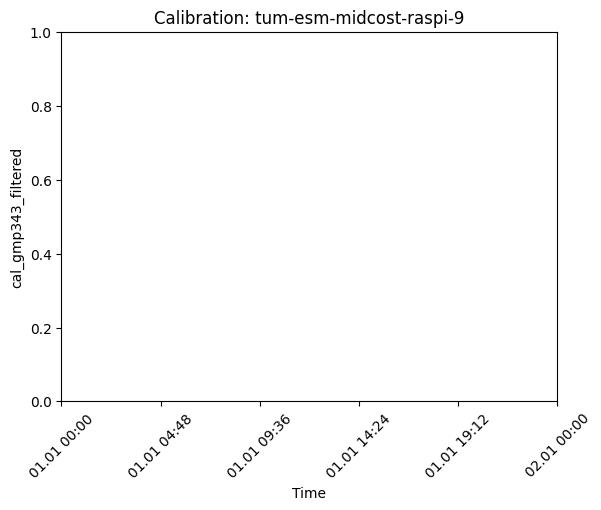

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

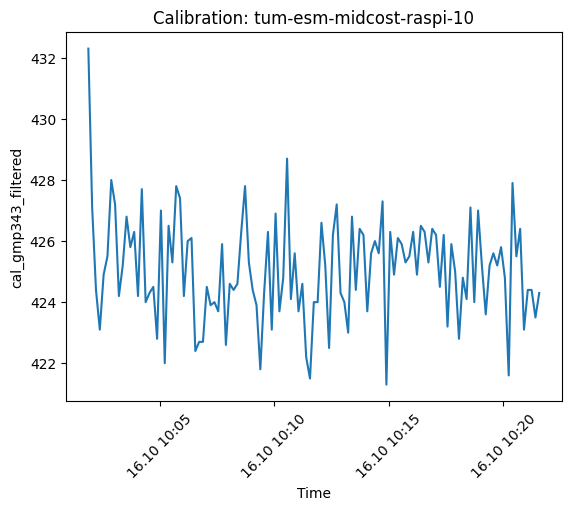

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

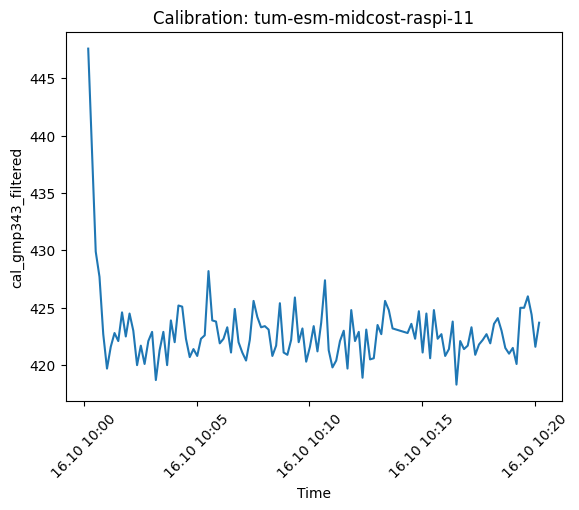

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

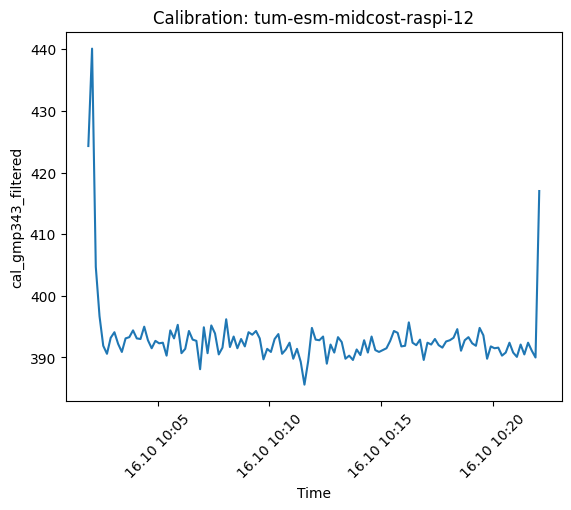

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

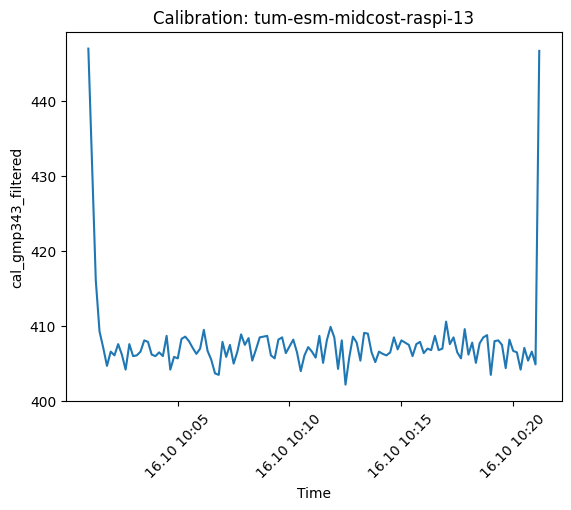

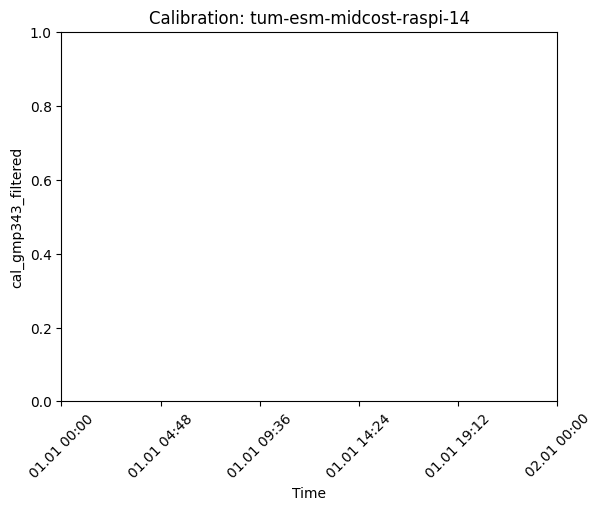

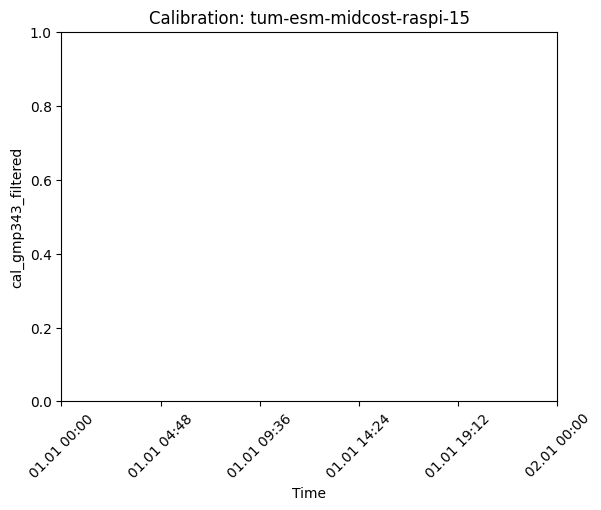

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

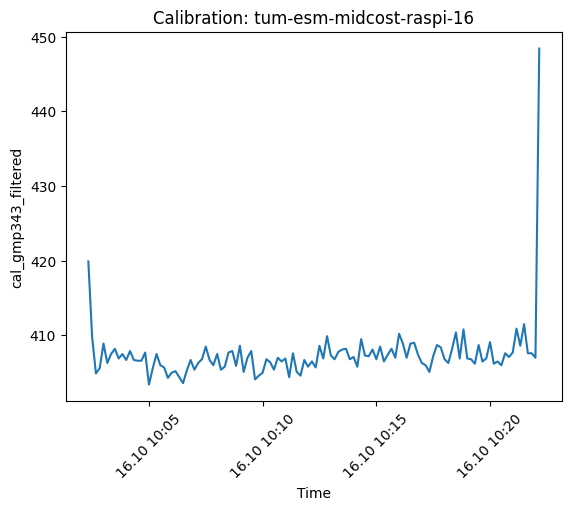

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

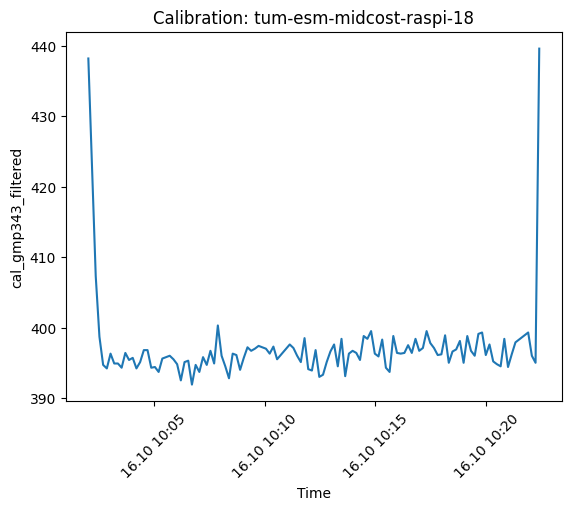

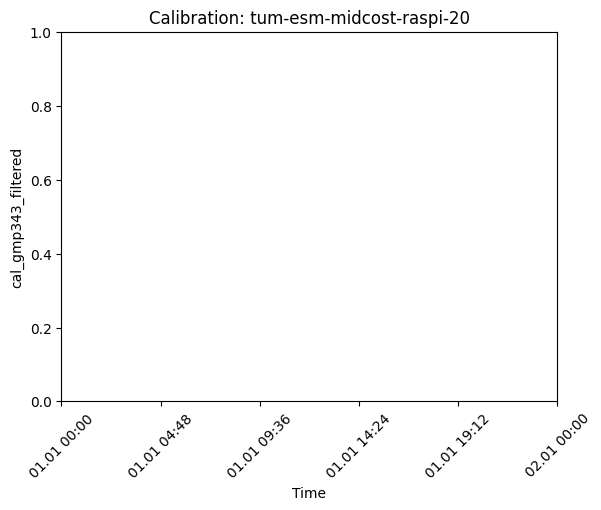

In [59]:
# Plot 400ppm Calibration Bottle 
plot_sensor_calibration(df, col_name = "cal_gmp343_filtered", sensor_id=sensor_id, filter = None, cut_above= 450, cut_below=350)


/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

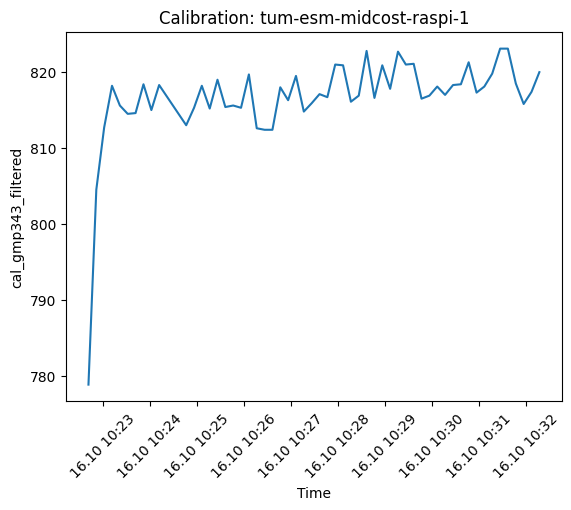

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

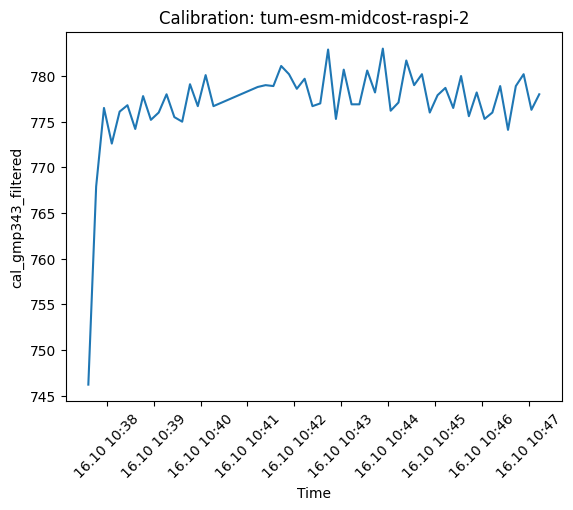

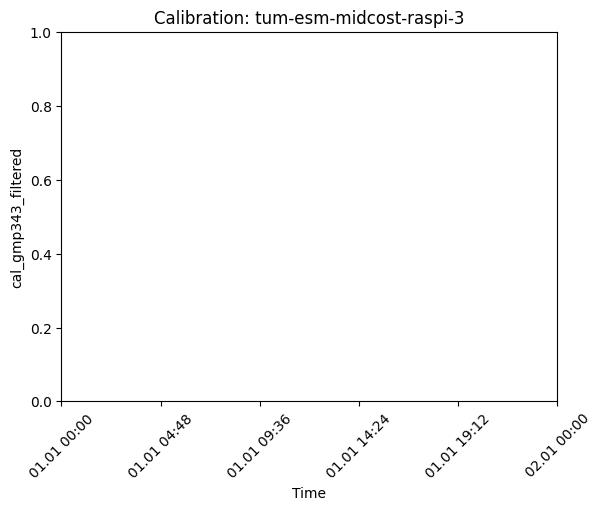

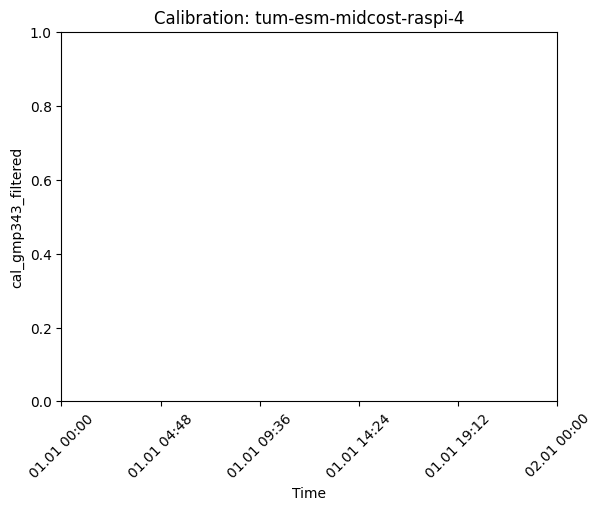

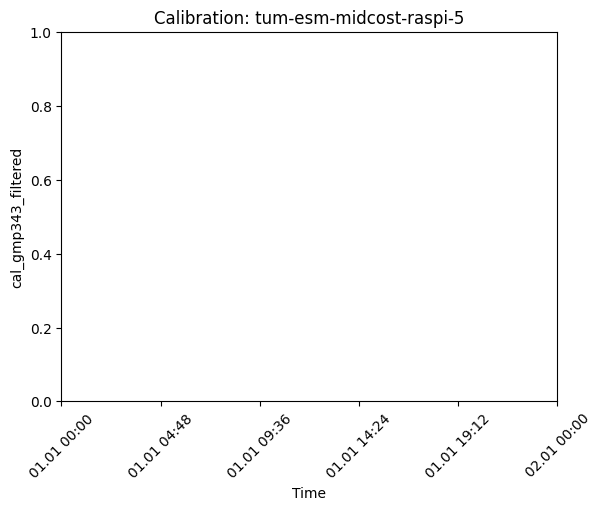

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

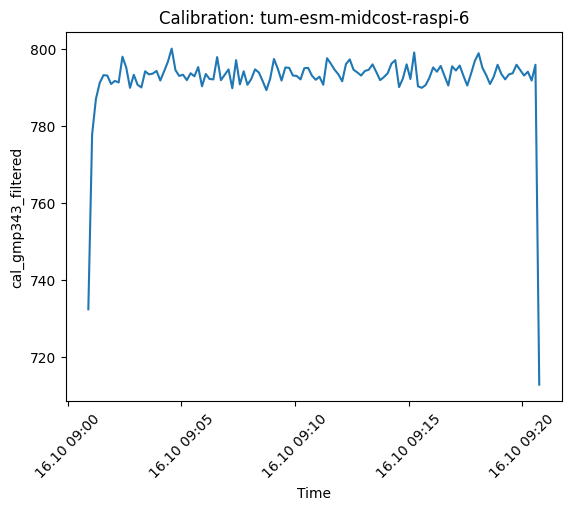

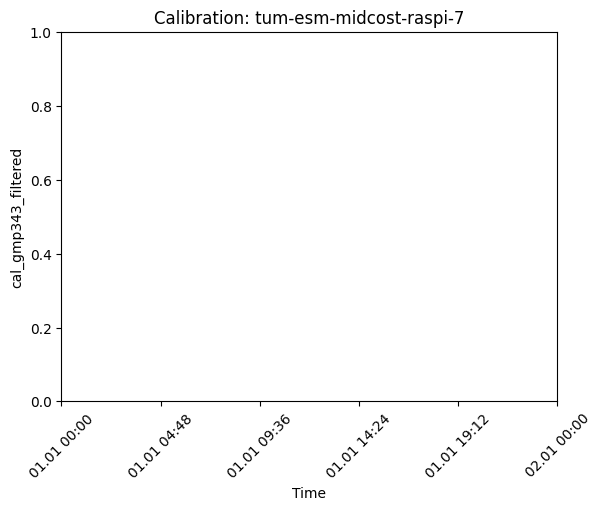

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

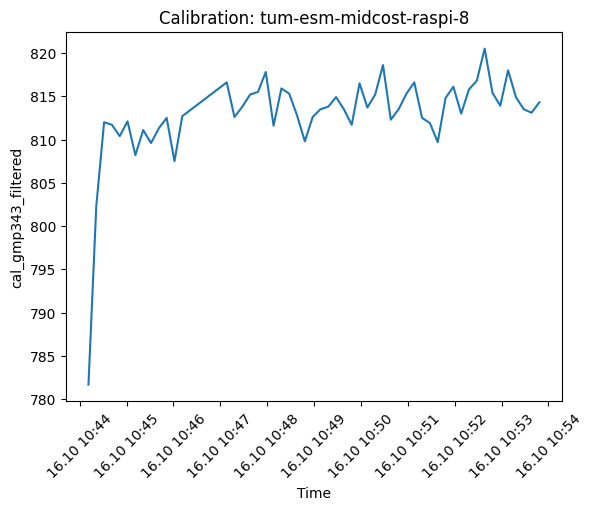

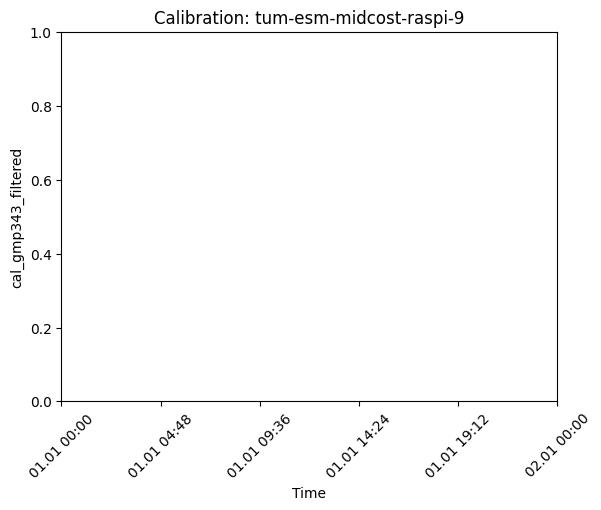

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

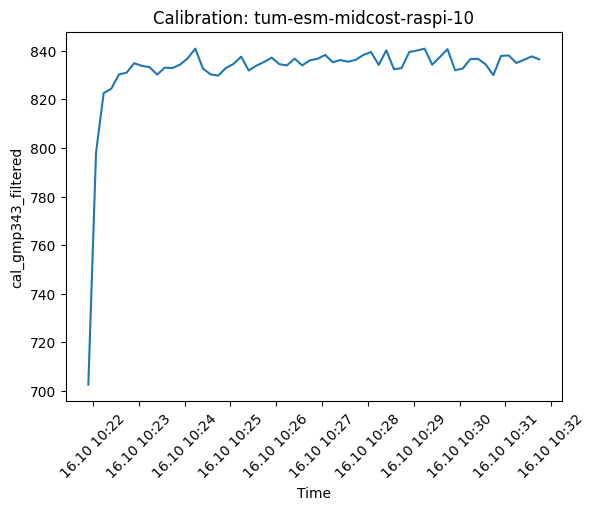

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

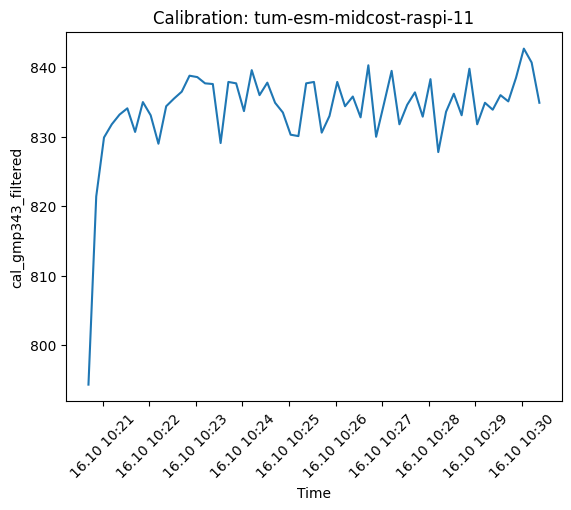

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

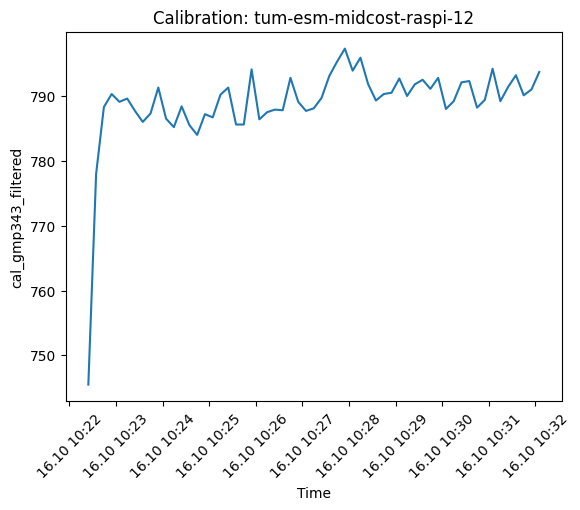

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

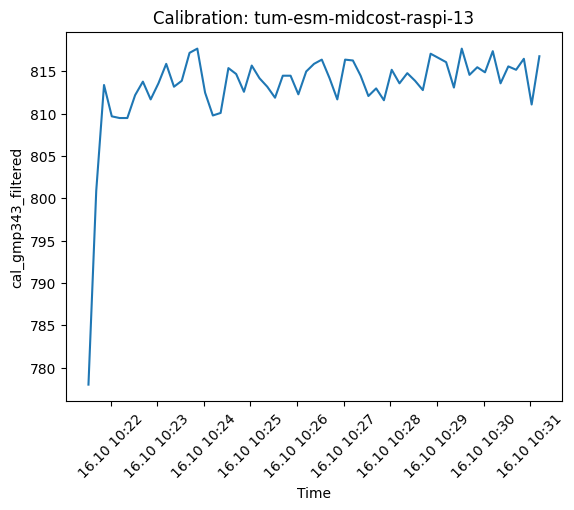

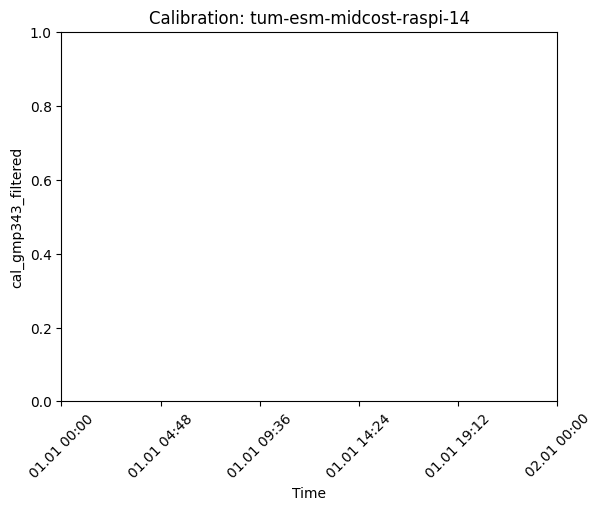

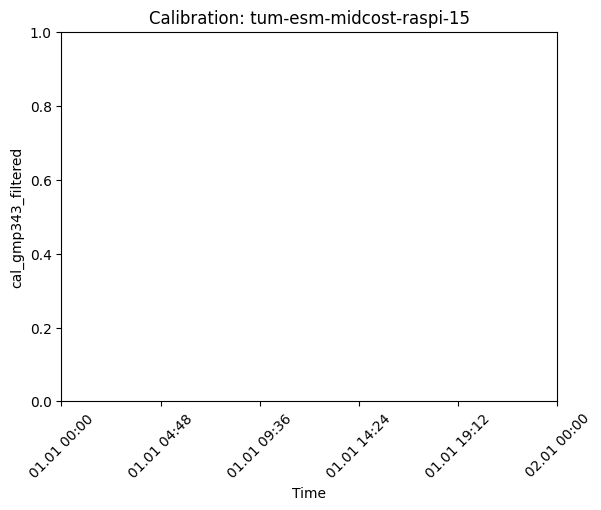

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

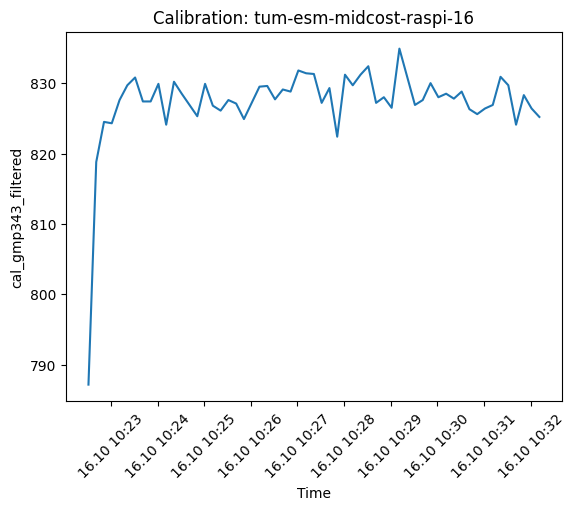

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

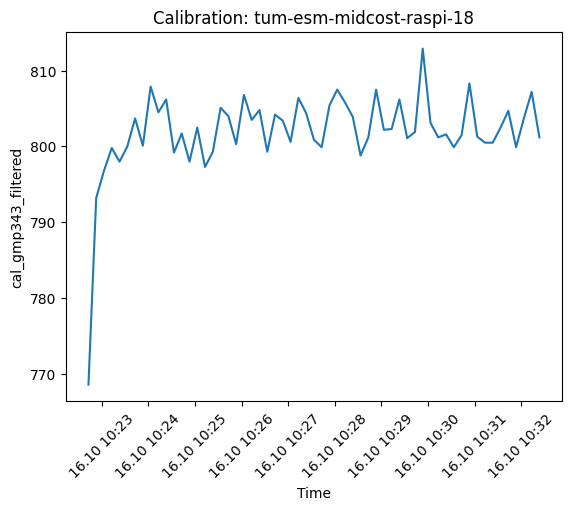

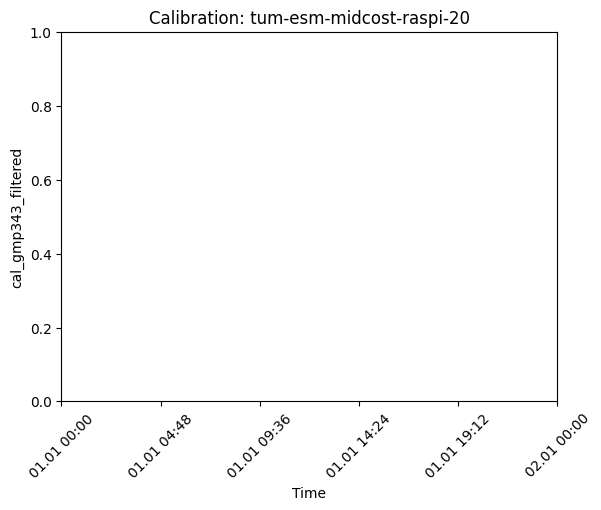

In [60]:
# Plot 800ppm Calibration Bottle 
plot_sensor_calibration(df, col_name = "cal_gmp343_filtered", sensor_id=sensor_id, filter = None, cut_below=700)